### Car detection and tracking using sliding window search

### NOTE: Most of the code has been reused from the Udacity lessons

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import pickle
from sklearn.externals import joblib
from scipy.ndimage.measurements import label

##### function from lession - extracting spacial features from an image

In [2]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

##### function from lession - extracting histogram of color features from an image

In [3]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

##### function from lession - extracting Histogram of Gradients features from an image

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

##### Visualizing HOG features

In [5]:
xcimg = cv2.imread('data/vehicles/GTI_MiddleClose/image0007.png')
xcimg = cv2.cvtColor(xcimg, cv2.COLOR_BGR2GRAY)
xncimg = cv2.imread('data/non-vehicles/GTI/image100.png')
xncimg = cv2.cvtColor(xncimg, cv2.COLOR_BGR2GRAY)

In [6]:
features_xc, hog_image_xc = get_hog_features(xcimg, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
features_xnc, hog_image_xnc = get_hog_features(xncimg, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)

Text(0.5,1,'HOG features of Non Car Image')

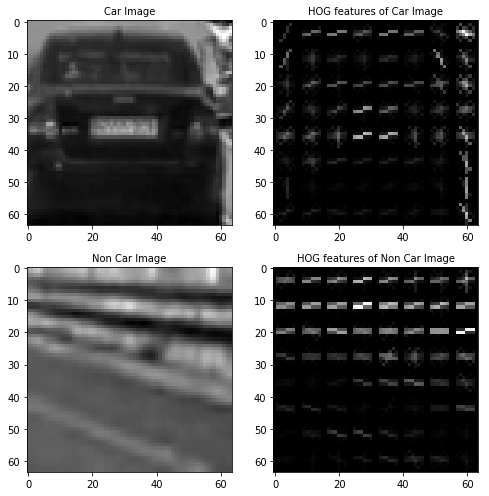

In [7]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7))
f.tight_layout()

ax1.imshow(xcimg, cmap='gray')
ax1.set_title('Car Image', fontsize=10)

ax2.imshow(hog_image_xc, cmap='gray')
ax2.set_title('HOG features of Car Image', fontsize=10)

ax3.imshow(xncimg, cmap='gray')
ax3.set_title('Non Car Image', fontsize=10)

ax4.imshow(hog_image_xnc, cmap='gray')
ax4.set_title('HOG features of Non Car Image', fontsize=10)

##### function from lession - extracting all the features from an image and prepare the feature matrix for training

In [8]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor(image, eval('cv2.COLOR_RGB2'+color_space))
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

##### functions from lession - train a classifier using Support Vector machines

In [9]:
car_images = glob.glob('data/vehicles/*/*.png')
noncar_images = glob.glob('data/non-vehicles/*/*.png')
cars = []
notcars = []
for image in car_images:
    cars.append(image)
    
for image in noncar_images:
    notcars.append(image)

In [10]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [11]:
t=time.time()
car_features1 = extract_features(cars, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features1 = extract_features(notcars, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

118.1 Seconds to extract HOG features...


In [13]:
# Create an array stack of feature vectors
X = np.vstack((car_features1, notcar_features1)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features1)), np.zeros(len(notcar_features1))))

In [14]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

##### use 'rbf' kernel to obtain a non-linear decision boundary

In [15]:
# Use a linear SVC 
svc = SVC(kernel='rbf')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

152.0 Seconds to train SVC...
Test Accuracy of SVC =  0.993
My SVC predicts:  [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
0.10548 Seconds to predict 10 labels with SVC


##### function from lession - extract all the featrues from an image 

In [17]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
            feature_image = cv2.cvtColor(img, eval('cv2.COLOR_RGB2'+color_space))
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

##### function from lession - finction to extract window coordinates from the given image

In [18]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

##### function from lession - method to draw a dox on the image

In [19]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

##### function from lession - extract features from each image window and classify using SVC

In [20]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat,hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [22]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [23]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

##### Pipeline to detect cars in a given images - returns images from different stages of processing

In [24]:
def detect_car(image, visualize=False, output_img='tmp.jpg'):
    
    width = image.shape[1]
    height = image.shape[0]
    y_start = int(height // 2)
    windows = []
    '''
    tiny_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[y_start, None], 
                        xy_window=(32, 32), xy_overlap=(0.5, 0.5))
    '''
    small_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[y_start, y_start+128], 
                        xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    medium_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[y_start, y_start+192], 
                        xy_window=(96, 96), xy_overlap=(0.85, 0.85))
    large_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[y_start, y_start+256], 
                        xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    huge_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[y_start, None], 
                        xy_window=(int(height // 4), int(height // 4)), xy_overlap=(0.5, 0.5))

    windows = small_windows + medium_windows + large_windows + huge_windows
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 

    window_img = draw_boxes(np.copy(image), hot_windows, color=(0, 0, 255), thick=6)  
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heatmap = apply_threshold(heat, 2)
    
    #heatmap = np.clip(heat, 0, 255)
    
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if visualize:
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
        f.tight_layout()

        ax1.imshow(window_img)
        ax1.set_title('Windowed Image', fontsize=20)

        ax2.imshow(heatmap, cmap='hot')
        ax2.set_title('Heat Map', fontsize=20)

        ax3.imshow(labels[0], cmap='gray')
        ax3.set_title('Labels', fontsize=20)

        ax4.imshow(draw_img)
        ax4.set_title('Detected Car Positions', fontsize=20)
        
        f.savefig(output_img)
    
    return window_img, heatmap, labels, draw_img

In [25]:
def detect_car_single(test_img, visualize=True, output_img='tmp.jpg'):
    img = cv2.imread(test_img)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return detect_car(image, visualize, output_img)

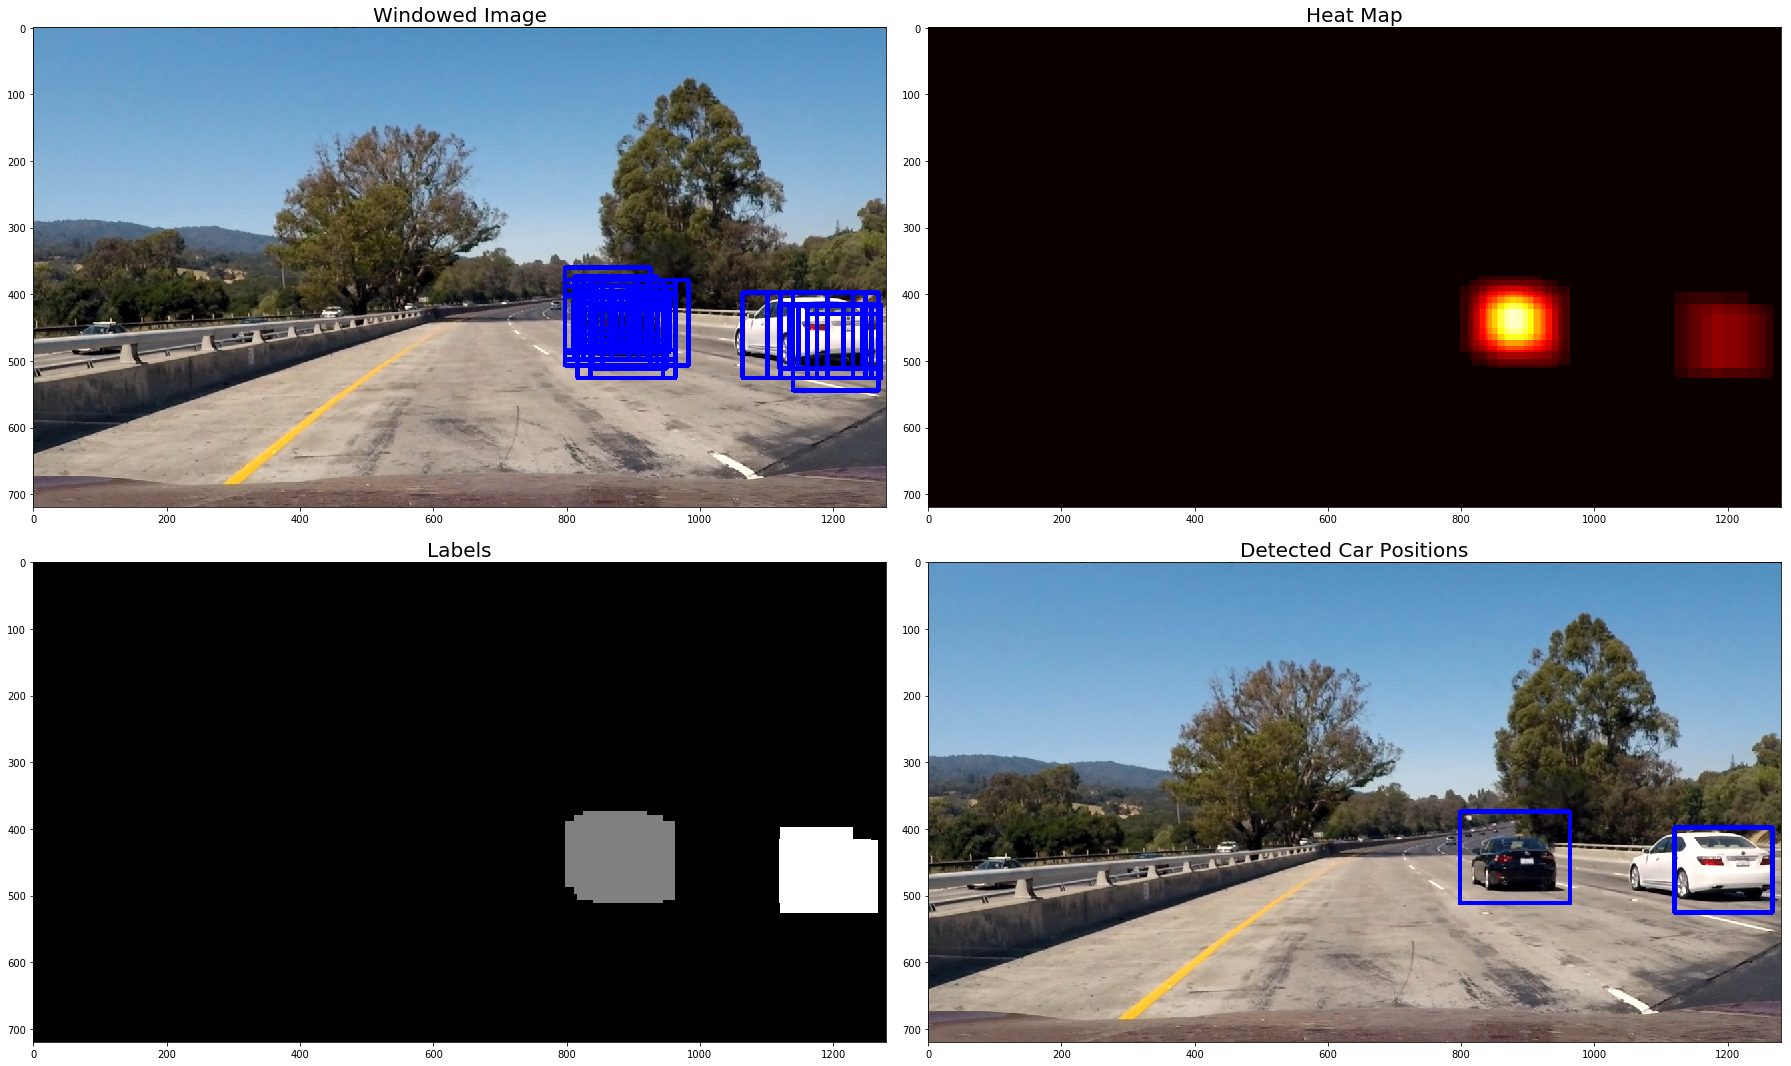

In [44]:
window_img, heatmap, labels, draw_img = detect_car_single('test_images/test1.jpg', True, 'output_images/test1-output.jpg')

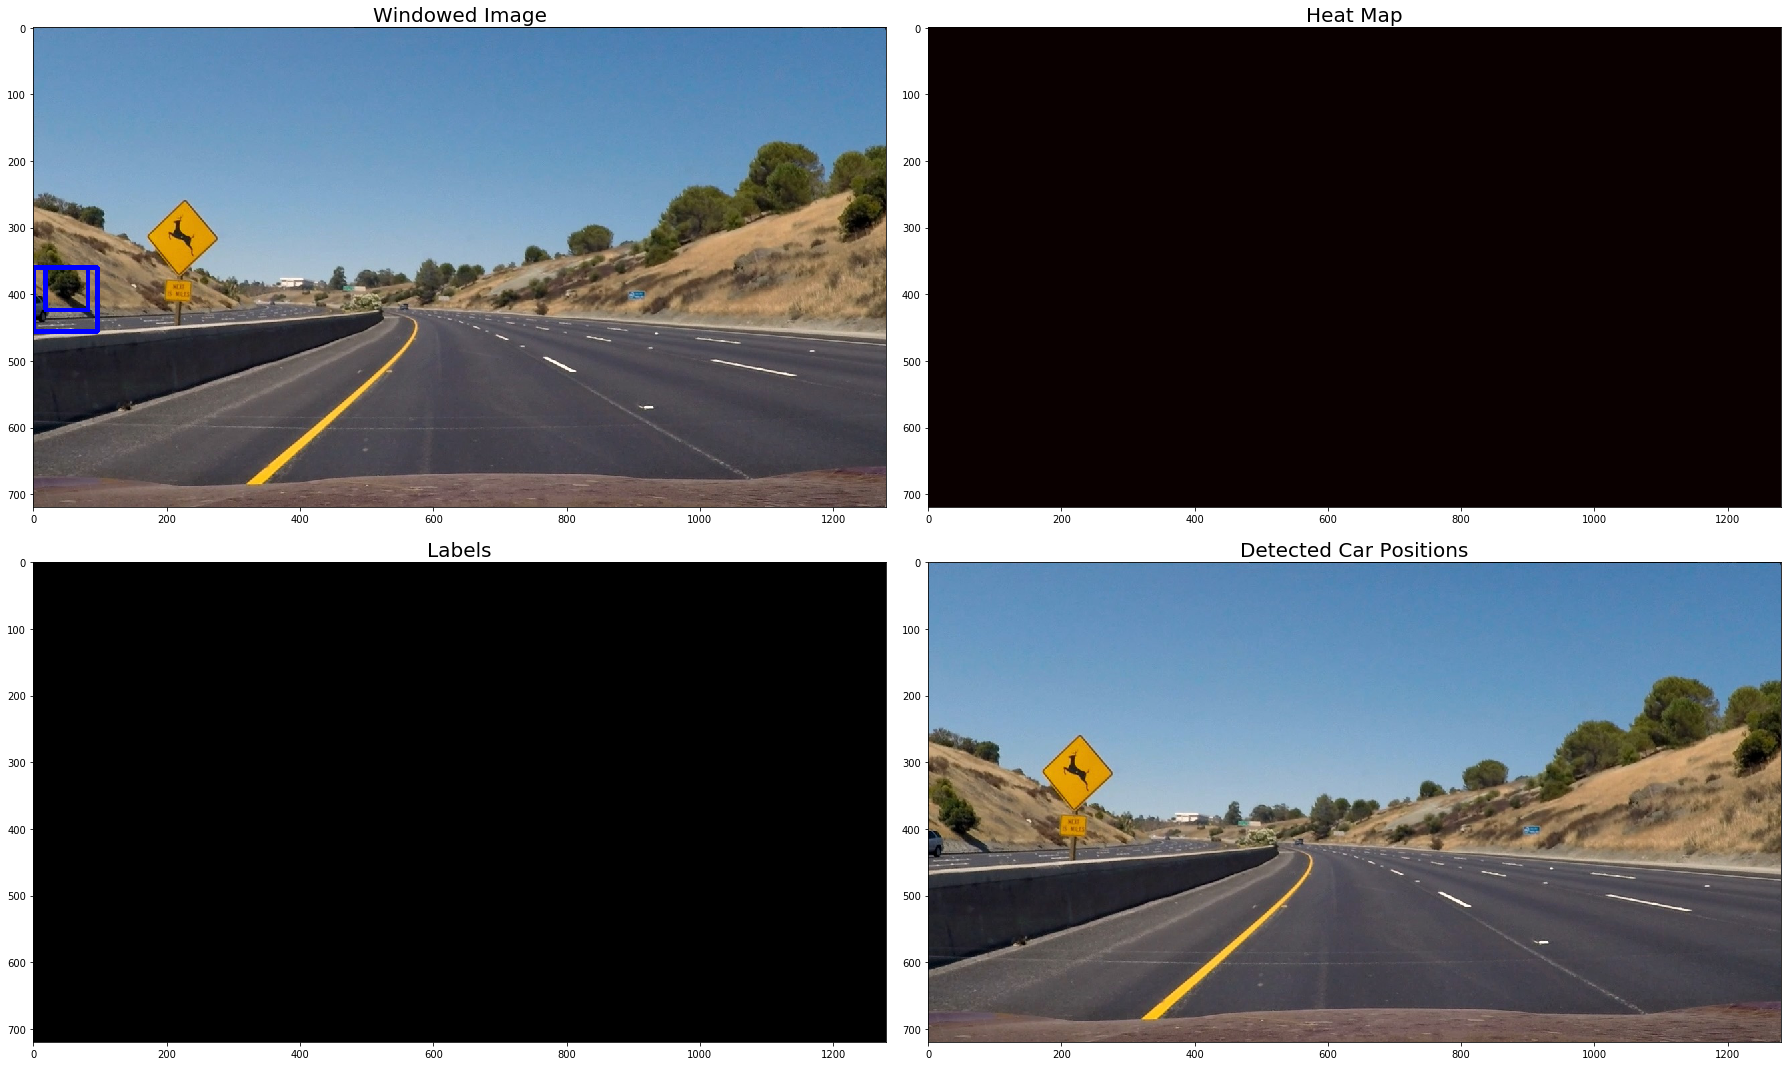

In [45]:
window_img, heatmap, labels, draw_img = detect_car_single('test_images/test2.jpg', True, 'output_images/test2-output.jpg')

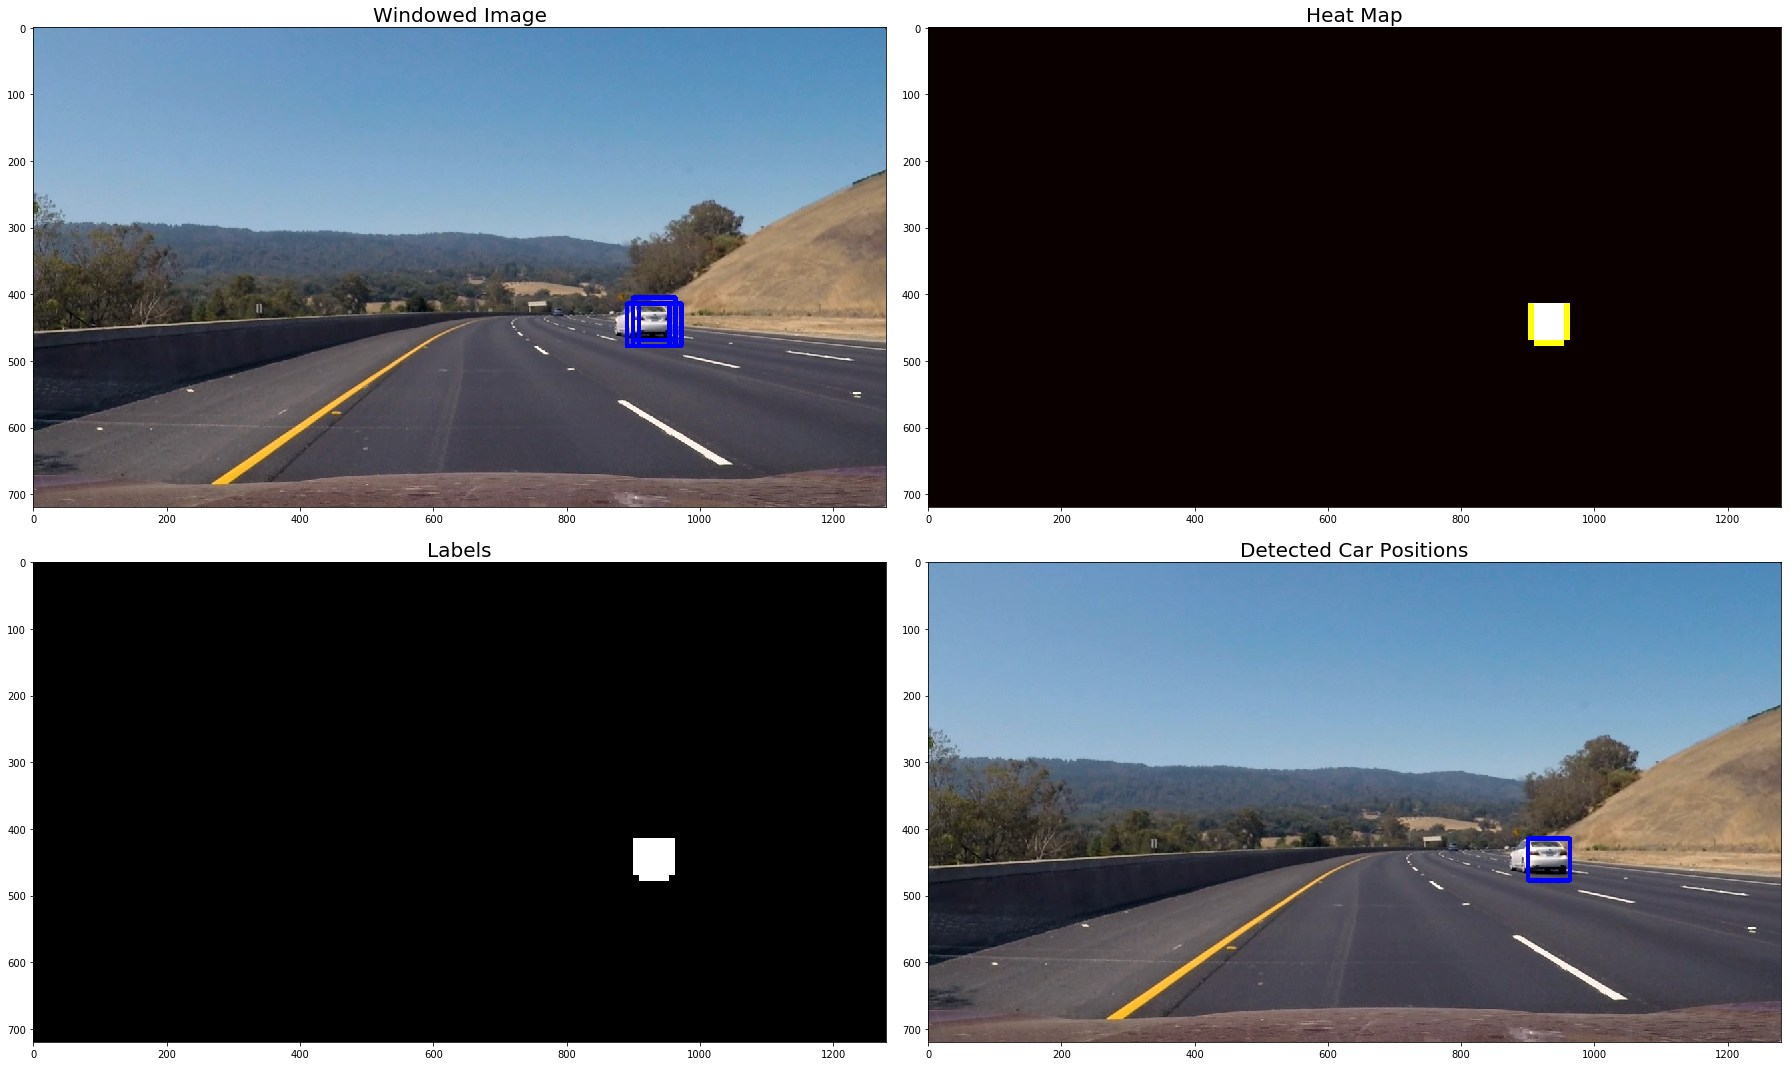

In [46]:
window_img, heatmap, labels, draw_img = detect_car_single('test_images/test3.jpg', True, 'output_images/test3-output.jpg')

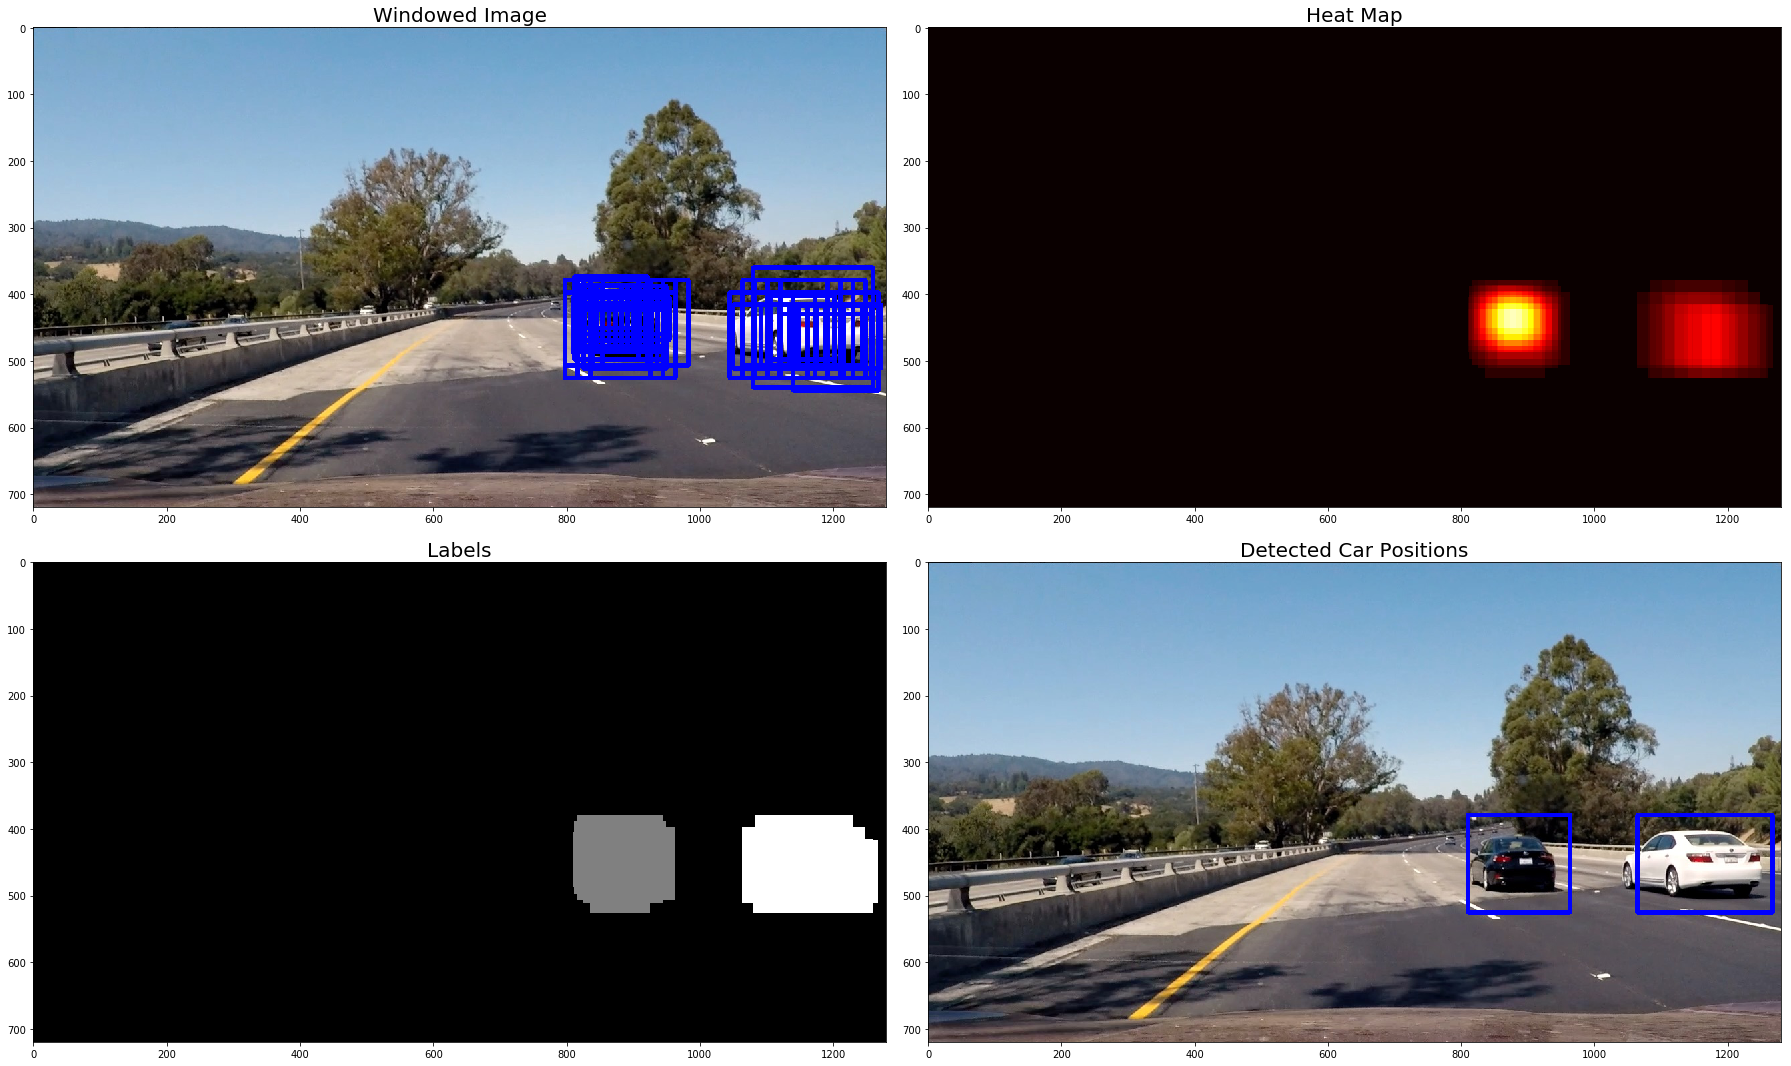

In [47]:
window_img, heatmap, labels, draw_img = detect_car_single('test_images/test4.jpg', True, 'output_images/test4-output.jpg')

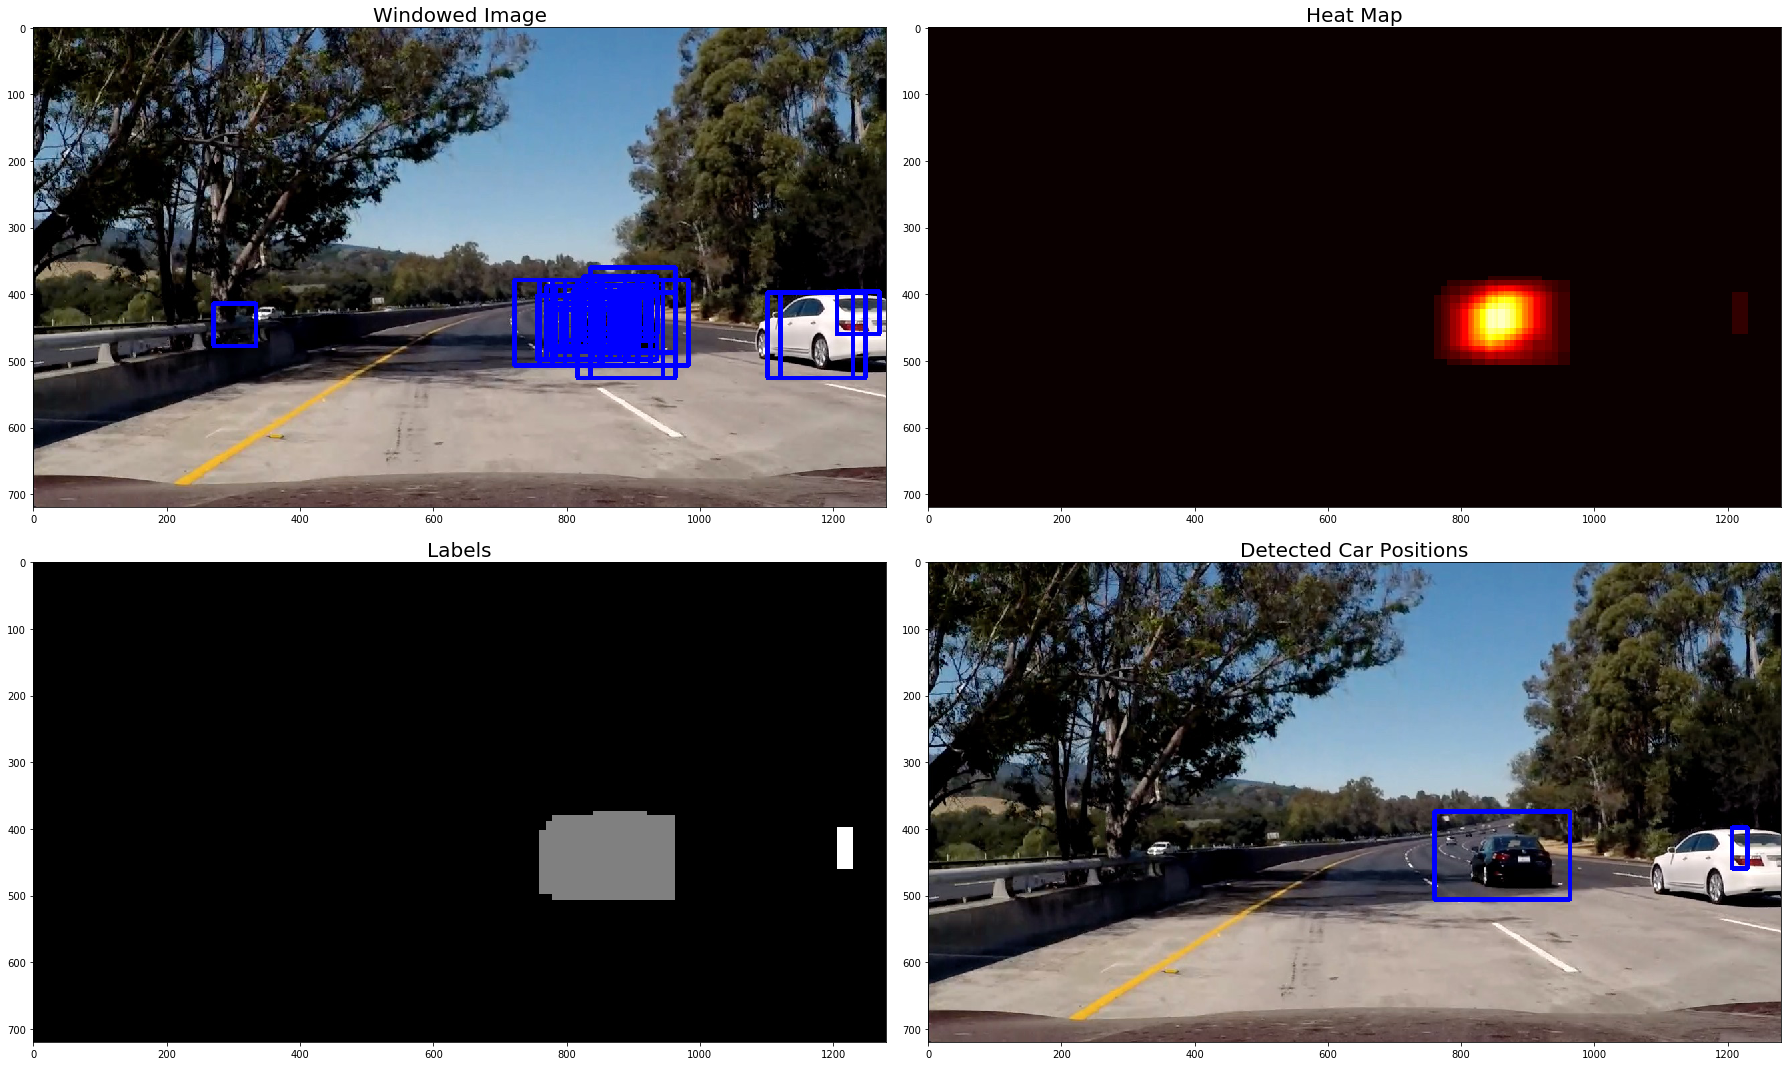

In [48]:
window_img, heatmap, labels, draw_img = detect_car_single('test_images/test5.jpg', True, 'output_images/test5-output.jpg')

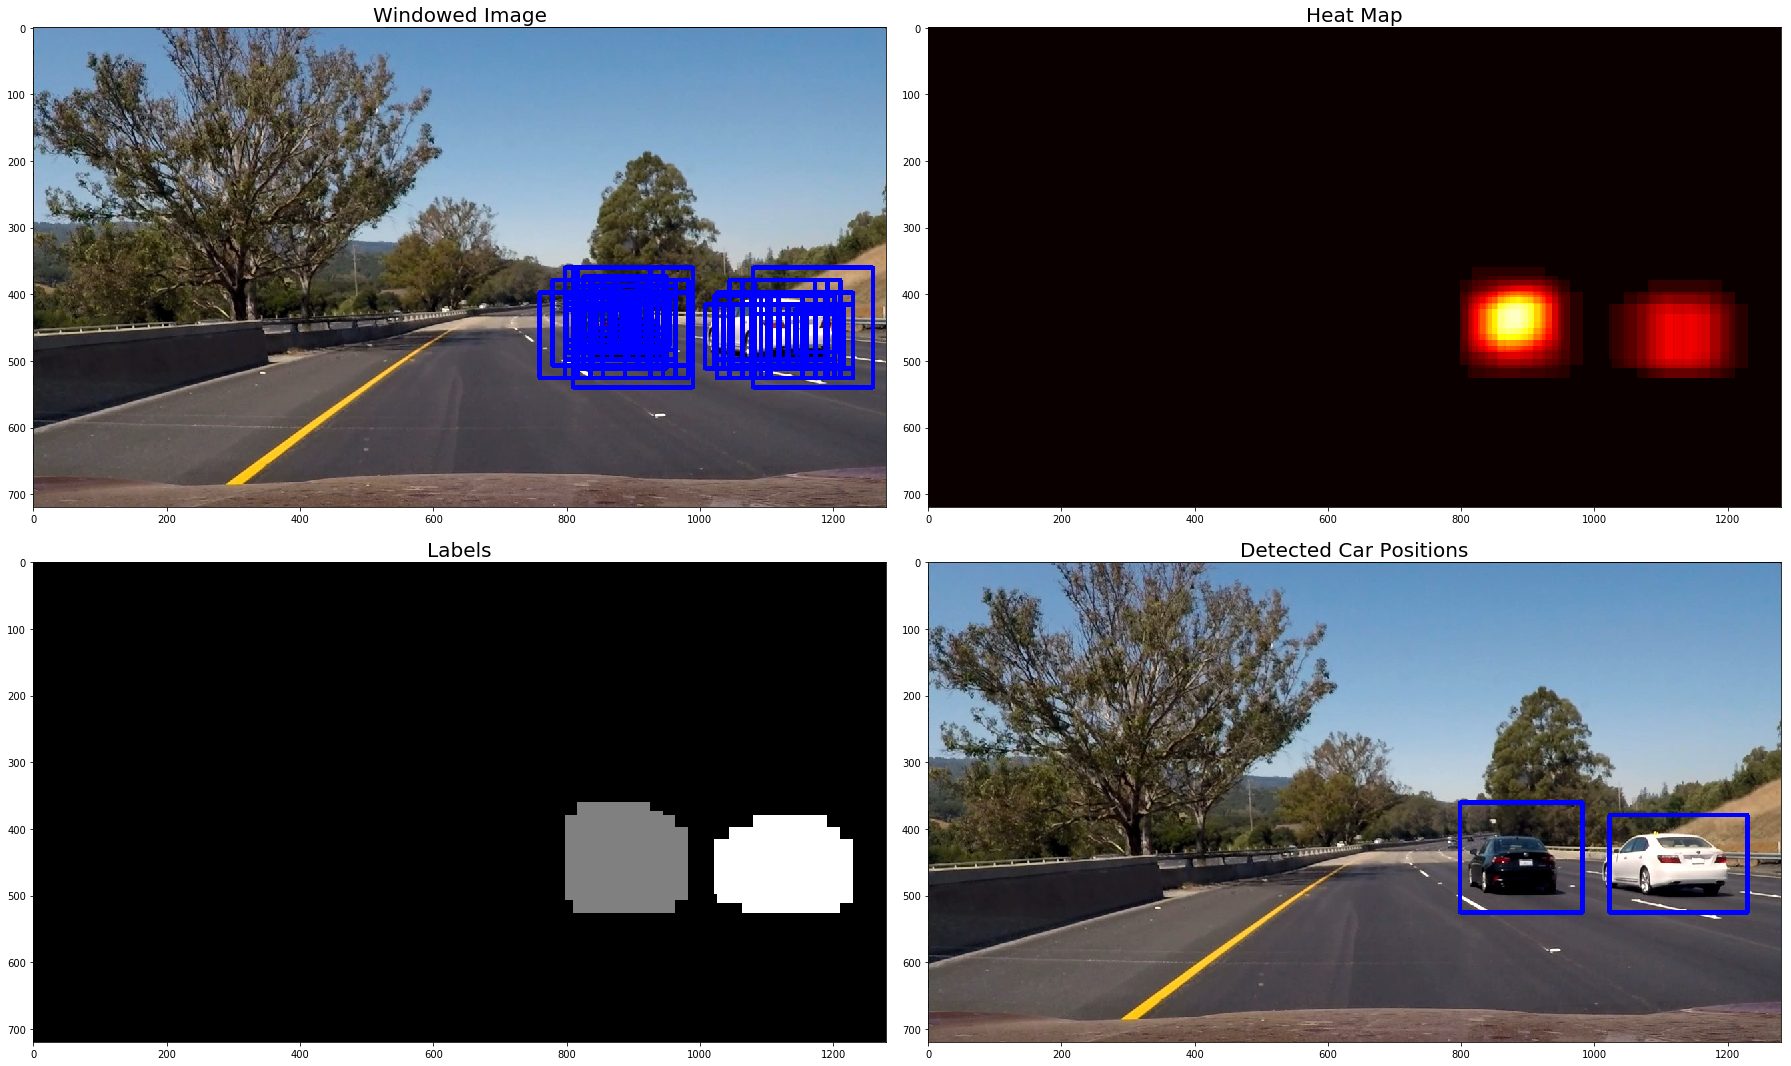

In [49]:
window_img, heatmap, labels, draw_img = detect_car_single('test_images/test6.jpg', True, 'output_images/test6-output.jpg')

In [26]:
def detect_car_stream(image):
    window_img, heatmap, labels, draw_img = detect_car(image)
    
    return draw_img

In [51]:
from moviepy.editor import VideoFileClip
import imageio
imageio.plugins.ffmpeg.download()
from IPython.display import HTML

In [52]:
test_video_input = 'test_video.mp4'
test_video_output = 'output_videos/test_video_output_m1_final.mp4'

In [53]:
clip1 = VideoFileClip(test_video_input)
clip = clip1.fl_image(detect_car_stream)
%time clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_video_output_m1_final.mp4
[MoviePy] Writing video output_videos/test_video_output_m1_final.mp4


 97%|█████████▋| 38/39 [23:15<00:35, 35.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video_output_m1_final.mp4 

CPU times: user 23min 12s, sys: 1.73 s, total: 23min 14s
Wall time: 23min 16s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_output))